In [20]:
import sys, os, glob
import numpy as np
import random
from astropy.table import Table
from astropy.io import ascii
from tessilator import tessilator
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import json


In [21]:
# choose the magnitude bins and number of targets per bin
mag_b, mag_d, mag_n = 10, 1, 6
mag_1s = mag_b + mag_d*np.arange(mag_n)
mag_2s = mag_b + mag_d + mag_d*np.arange(mag_n)
n_bin = 10

In [22]:
# read in the large 4SYS periods table
if 'tab_per' not in locals():
    tab_per = ascii.read('./4SYS/TESS_4SYS_FOR_SIMULATION.csv')

In [23]:
# select the sector, camera, ccd configuration
Sector, Camera, CCD = 1, 1, 1
extn_scc = f'{Sector:02d}_{Camera}_{CCD}'
dir_base = f'./tesssim/lc/{extn_scc}'

In [24]:
amps = np.logspace(-6, -1, num=9)
periods = np.logspace(-1, 1.2, num=23)
num_phase_shifts = 10

#big run
#amps = np.logspace(-5, -1, num=25)
#periods = np.logspace(-1.0, 1.2, num=23)
#num_phase_shifts = 100
jitter_frac = 0.05

In [25]:
# collect the subsample bins, for targets that are
# best fit with a straight line rather than sinusoidal
# e.g., flat, noisy lightcurves
for mag_1, mag_2 in zip(mag_1s, mag_2s):
    extn_mag = f'{mag_1}_{mag_2}'
    lc_dir=f'tesssim/lc/{extn_scc}/mag_{extn_mag}'
    lc_files = glob.glob(f'{lc_dir}/lc*.csv')
    if not lc_files:
        g = tab_per[
                    (tab_per['Sector']==Sector) & \
                    (tab_per['Camera']==Camera) & \
                    (tab_per['CCD']==CCD) & \
                    (tab_per['Gmag'] > mag_1) & \
                    (tab_per['Gmag'] < mag_2) & \
                    (tab_per['AIC_sine'] - tab_per['AIC_line'] > 1.5)
                   ]
        # if there are more than n_bin matches, take a random subsample of "n_bin" targets
        if len(g) > n_bin:
            sub_sample = g[np.random.choice(len(g), n_bin)]
        else:
            sub_sample = g
        source_ids = [s for s in sub_sample['source_id'].data]
        if source_ids:
            tab_info = dict()
            tab_info['source_id'] = source_ids
            tab_in = Table(tab_info)
            tTargets = tessilator.read_data(tab_in)
            tessilator.all_sources_cutout(tTargets, f'tesssim_{extn_scc}_{extn_mag}', 0, 0, '_', 0,\
                                          choose_sec=Sector, store_lc=True, tot_attempts=2, cap_files=1,\
                                          lc_dir=lc_dir)
    

In [26]:
def get_lc_data(files, directory, n_bin=10):
    num, time, flux, eflux = [], [], [], []
    d_points, n_diff = [], []
    if len(files) > n_bin:
        chosen_indices = np.random.choice(len(files), n_bin)
        files_chosen = [files[n] for n in chosen_indices]
    else:
        files_chosen = files
    for f, file in enumerate(files_chosen):
        tab = ascii.read(file)
        d_points.append(len(tab))
        n_diff.append(np.median(np.diff(tab['time'])))
        for t in tab:
            num.append(f+1)
            time.append(t['time'])
            flux.append(t['nflux'])
            eflux.append(t['enflux'])
    t0, t1, tn, t_diff = min(time), max(time), np.median(d_points), np.median(n_diff)
    t_arr = np.linspace(t0, t1, num=int(tn))
    num, time, flux, eflux = np.array(num), np.array(time), np.array(flux), np.array(eflux)
    dict_lc = defaultdict(list)
    for t in t_arr:
        for ind in 1+np.arange(len(files_chosen)):
            g = np.where(num == ind)[0]
            t_min = min(abs(time[g] - t))
            t_test = t_min < 2.0*t_diff
            if t_test:
                dict_lc[f'{t}'].append(np.interp(t, time[g], flux[g]))
    t_fin = Table(names=('time', 'nflux', 'enflux', 'n_lc'), dtype=(float, float, float, int))
    for n, (k, v) in enumerate(dict_lc.items()):
        if len(files) > 2:
            t_fin.add_row([k, np.median(v), eflux[n], len(v)])
        else:
            t_fin.add_row([k, np.mean(v), eflux[n], len(v)])                
        t_fin.write(f'{directory}/flux_fin.csv', overwrite=True)
    return t_fin

In [27]:
def make_lc_plots(files, med_lc, directory):
    fig, ax = plt.subplots(figsize=(10,7))
    for file in files:
        tab = ascii.read(file)
        ax.scatter(tab['time'], tab['nflux'])
    ax.scatter(med_lc['time'], med_lc['nflux'], s=40, c='black')
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Normalised flux')
    fig.savefig(f'{directory}/med_lc.png', bbox_inches='tight')
    fig.clf()

In [28]:
def make_sine(amp, period, phase, time):
    return amp*np.sin(phase + 2.*np.pi*time/period)

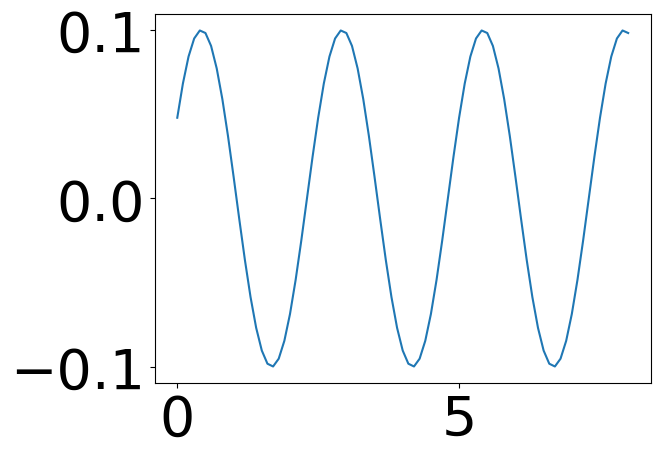

In [29]:
time = np.linspace(0, 8, num=81)
amp, period, phase = 0.1, 2.5, 0.5
y = make_sine(amp, period, phase, time)
plt.plot(time, y)

In [30]:
sim_file = f'{dir_base}/sim_file.dat'
if os.path.exists(sim_file):
    with open(f'{sim_file}', "r") as fp:
        sim_res = json.load(fp)

else:
    directories = sorted(glob.glob(f'{dir_base}/mag_*'))
    sim_res = defaultdict(list)
    for directory in directories:
        d_spl = directory.split("_")
        mag_1, mag_2 = d_spl[-2], d_spl[-1]
        files = glob.glob(f'{directory}/lc*')

        med_lc = get_lc_data(files, directory, n_bin=n_bin)
        make_lc_plots(files, med_lc, directory)
        LS_dict = tessilator.run_ls(med_lc)
        sim_res['orig_periodLS'].append(LS_dict['Gauss_fit_peak_parameters'][1])
        sim_res['orig_e_periodLS'].append(LS_dict['Gauss_fit_peak_parameters'][2])

        for amp in amps:
            for period in periods:
                n_match = 0
                for n_ps in range(num_phase_shifts):
                    new_lc = dict()
                    jitter_x = np.random.normal(0, period*jitter_frac, size=len(med_lc))
                    jitter_y = np.random.normal(0, amp*jitter_frac, size=len(med_lc))

                    new_lc['enflux'] = med_lc['enflux']
                    phase = np.random.uniform(low=0., high=2.*np.pi)
                    error = [np.random.normal(0, sigma) for sigma in new_lc['enflux']]

                    new_lc['time'] = med_lc['time'] + jitter_x

                    new_lc['nflux'] = med_lc['nflux'] + \
                                      error + \
                                      jitter_y + \
                                      make_sine(amp, period, phase, med_lc['time'])

                    if (amp == amps[0]) & (period == periods[3]):
                        fig, ax = plt.subplots(figsize=(10,5))
                        sort_time = np.argsort(new_lc['time'])
                        ax.plot(new_lc['time'][sort_time], new_lc['nflux'][sort_time])
                        fig.savefig(f'{directory}/sine_plot.png', bbox_inches='tight')
                        plt.close()
                    LS_dict = tessilator.run_ls(new_lc)
                    periodLS = LS_dict['Gauss_fit_peak_parameters'][1]
                    e_periodLS = LS_dict['Gauss_fit_peak_parameters'][2]
#                    print(f'mag: {directory}, amp: {amp}, phase number: {n_ps+1}/{num_phase_shifts}')
#                    print(f'period: {period}')
#                    print(f'periodLS: {periodLS}+/-{e_periodLS}')
#                    print()
                    if abs(period-periodLS) < e_periodLS:
                        n_match += 1
                sim_res['mag_1'].append(mag_1)
                sim_res['mag_2'].append(mag_2)
                sim_res['amp'].append(amp)
                sim_res['period'].append(period)
                sim_res['n_frac'].append(1.*n_match/num_phase_shifts)
    with open(f'{sim_file}', "w") as fp:
        json.dump(sim_res, fp)  # encode dict into JSON


3.430761250156161 0.25673398491154603
4.340282835278835 0.6107583776314579
2.401188047217734 0.1875160769166764
9.134896543768821 1.9465663054575362
3.5201194018307853 0.2717973514908312


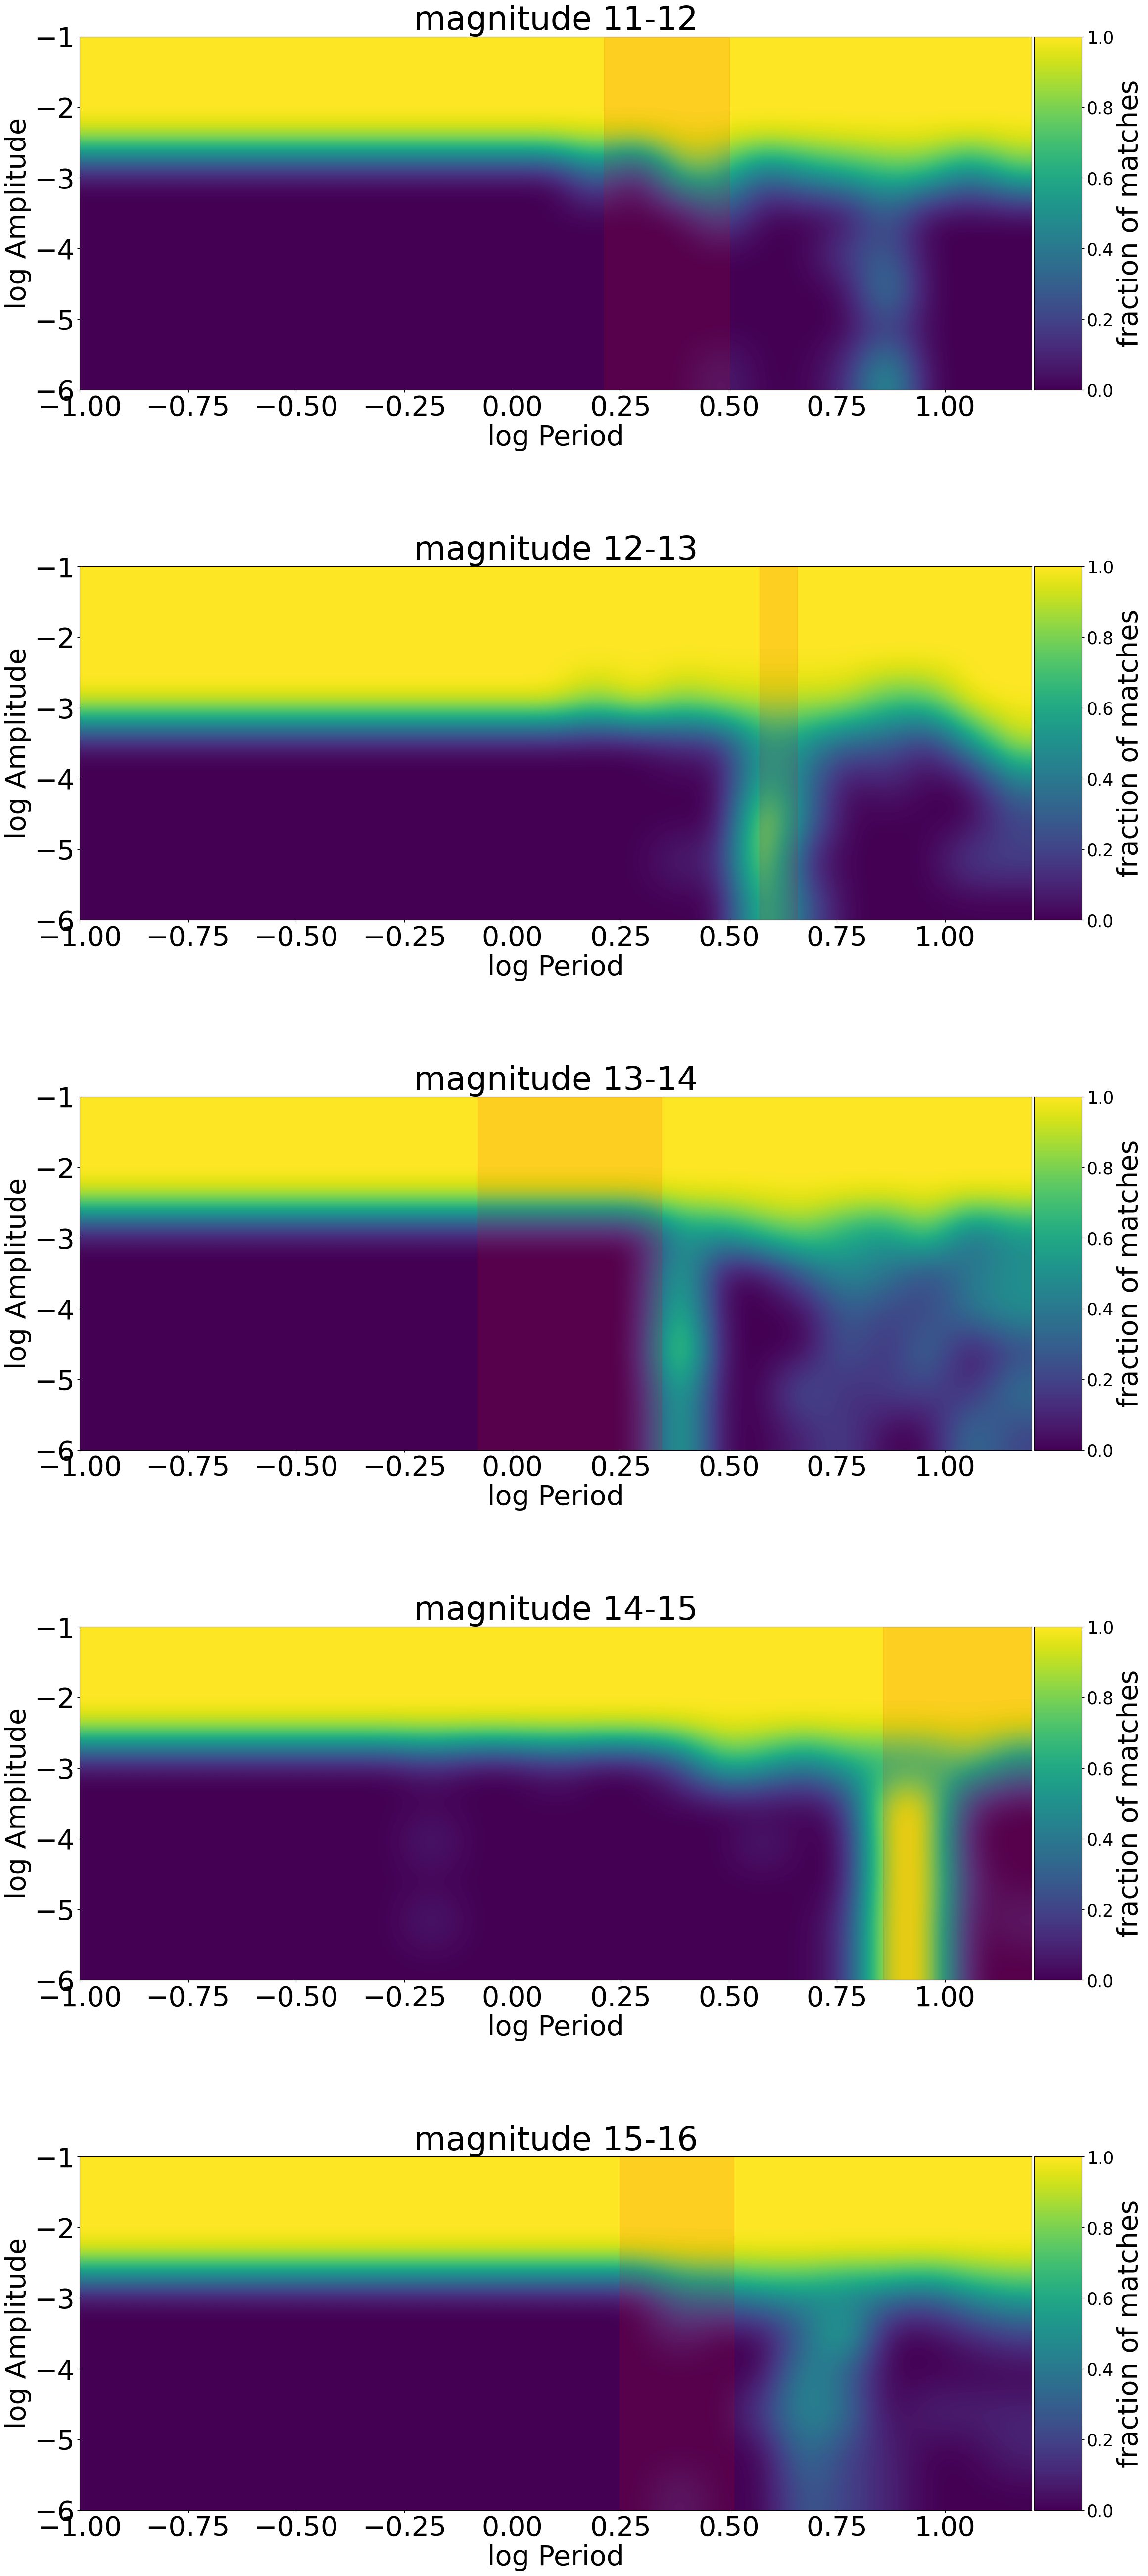

In [31]:
mags = np.unique(sim_res['mag_1'])
fig, ax = plt.subplots(nrows=len(mags), ncols=1, figsize=(30,100))
plt.rcParams.update({'font.size': 40})
for i, mag in enumerate(mags):
    o_ps = sim_res['orig_periodLS'][i]
    o_eps = sim_res['orig_e_periodLS'][i]
    xx, yy = np.meshgrid(np.log10(periods), np.log10(amps))
    g = np.where(np.array(sim_res['mag_1']) == mag)[0]
    n_frac = np.array(sim_res['n_frac'])[g].reshape(len(amps), len(periods))
    n_frac = n_frac[::1][::-1]
    z_min, z_max = min(n_frac.ravel()), max(n_frac.ravel())

    ax[i].set_title(f'magnitude {int(mag)}-{int(mag)+1}')
    # set the limits of the plot to the limits of the data
    ax[i].set_xlabel('log Period')
    ax[i].set_ylabel('log Amplitude')
    im = ax[i].imshow(n_frac, cmap='viridis',
                      interpolation='bicubic', 
                      vmin=z_min, vmax=z_max,
                      aspect='auto',
                      extent=[xx.min(), xx.max(), yy.min(), yy.max()])
    print(o_ps, o_eps)
    rect = patches.Rectangle((np.log10(o_ps-o_eps),yy.min()),
                              np.log10(2.*o_eps),
                              yy.max()-yy.min(),
                              linewidth=1, edgecolor='r',
                              facecolor='r', alpha=0.1)
    ax[i].add_patch(rect)

    
    
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, label='fraction of matches')
    plt.subplots_adjust(bottom=0.4, right=0.8, top=0.9)
    cbar.ax.tick_params(labelsize=25)

fig.subplots_adjust(wspace=0, hspace=0.5)    
fig.savefig(f'{dir_base}/amp_mag_heatmap.png', bbox_inches='tight')

#    fig.colorbar(im, ax=ax, label='fraction of matches')
#fig.show()